In [196]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [773]:
!pip install seaborn

     |████████████████████████████████| 225kB 1.1MB/s eta 0:00:01


In [2]:
import seaborn as sb

## Read in D Matrices
These are matrices outputted by oc.cpp that are the same dimensions of their respective images.  
Each entry in the matrix corresponds to the likelihood that a person would walk in that cell.  
That is, the higher an entry is, the more likely it is that a person will traverse that cell.
TODO: implement a DFS-style algorithm that, given a start and end point, finds the best path through the predicted trajectory

In [2]:
# converts D matrix to np array
def convertDToNumpy(path):
    ret = []
    with open(path) as f:
        lines = f.read().splitlines()
        lines[0] = lines[0].strip("[")
        lines[len(lines) - 1] = lines[len(lines) - 1].strip("]")
        
        # go through each row and strip semi-colon
        for l in lines:
            l = l.strip(";")
            ret.append([float(i) for i in l.split(', ')])
        
        # convert to np array and return
        return np.array(ret)

In [177]:
# test convertDToNumpy
import os

# stems = ["walk_suburban_"]
stems = ["walk_suburban_", 
         "walk_barcelona_", 
         "walk_timessquare_", 
         "walk_perspective_", 
         "walk_sanmarco_", 
         "walk_turin_", 
         "walk_london_",
         "walk_cityscapes_"]

end = "_D.txt"
directory = "D_matrices/"
paths = os.listdir("D_matrices/")
paths_dict = {}
filenames_dict = {}

# slot each filename into a dict
for i in range(len(stems)):
    filenames_dict[stems[i]] = [(directory + name) for name in paths if name.startswith(stems[i]) and name.endswith(end)]
    paths_dict[stems[i]] = [convertDToNumpy(directory + name) for name in paths if name.startswith(stems[i]) and name.endswith(end)]
    print(len(paths_dict[stems[i]]), len(filenames_dict[stems[i]]))
    

5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5


In [178]:
# extract source and dest information from filename
sources, dests = {}, {}
for i in range(len(stems)):
    sources[stems[i]] = []
    dests[stems[i]] = []
    for j in range(len(paths_dict[stems[i]])):
        # cut off directory + walk_* from filename
        curr = filenames_dict[stems[i]][j][len(directory + stems[i]):]
        curr = curr.split("_")
        sources[stems[i]].append([int(curr[1]), int(curr[0])])
        dests[stems[i]].append([int(curr[3]), int(curr[2])])

print(sources)
print(dests)

{'walk_suburban_': [[198, 380], [159, 267], [193, 250], [159, 267], [162, 236]], 'walk_barcelona_': [[118, 215], [140, 115], [134, 361], [113, 205], [122, 167]], 'walk_timessquare_': [[62, 148], [75, 28], [19, 256], [149, 137], [93, 380]], 'walk_perspective_': [[81, 243], [100, 362], [153, 181], [96, 318], [165, 126]], 'walk_sanmarco_': [[184, 188], [101, 323], [189, 212], [95, 284], [200, 334]], 'walk_turin_': [[213, 363], [213, 363], [214, 37], [95, 213], [153, 380]], 'walk_london_': [[188, 277], [213, 219], [159, 219], [155, 249], [213, 363]], 'walk_cityscapes_': [[144, 9], [157, 359], [99, 131], [111, 370], [103, 280]]}
{'walk_suburban_': [[159, 268], [215, 373], [163, 123], [193, 373], [215, 322]], 'walk_barcelona_': [[183, 0], [129, 254], [214, 320], [214, 205], [189, 383]], 'walk_timessquare_': [[102, 163], [116, 0], [28, 133], [131, 382], [39, 149]], 'walk_perspective_': [[150, 215], [104, 183], [215, 198], [151, 227], [210, 155]], 'walk_sanmarco_': [[126, 283], [109, 237], [12

## Convert Likelihood Matrix into a Cost Matrix
Currently, each entry in the D matrix corresponds to the likelihood of a pedestrian walking into that square.  
We need a function that maps each likelihood to a cost, such that the higher the cost of an entry, the less likely a pedestrian is to walk into that square. This will result in the minimum cost path also being the most likely path.  
The process for creating the cost matrix is the following:
- map each likelihood to be in an interval of [0, 1]. 
- transform each entry by a function that maps likelihood to cost. This function could be of many forms (c = 1 - likelihood, c = 1 / likelihood, c = (1 - likelihood) ^ n, c = (1 / likelihood) ^ n, etc) so see which one ultimately results in the smoothest paths.
- an optional but potential smoothing step: apply a Gaussian filter to the cost matrix to smooth it.

In [179]:
cost_mats = {}
for i in range(len(stems)):
    cost_mats[stems[i]] = []
    for j in range(len(paths_dict[stems[i]])):
        mat = np.copy(paths_dict[stems[i]][j])
        cost_mats[stems[i]].append(mat / np.amax(mat)) # normalize        
    
print(np.amin(cost_mats[stems[0]][0]), np.amax(cost_mats[stems[0]][0]))

0.0 1.0


In [180]:
def likelihood_to_cost(x, fx, exp):
    if fx == 0:
        return (1 - x) ** exp
    else:
        return (1 / (x + 0.0001)) ** exp

In [181]:
fx = 1
exp = 2

for i in range(len(stems)):
    for j in range(len(cost_mats[stems[i]])):
        cost_mats[stems[i]][j] = np.array([likelihood_to_cost(x, fx, exp) for x in cost_mats[stems[i]][j]])

## Visualize Cost matrix

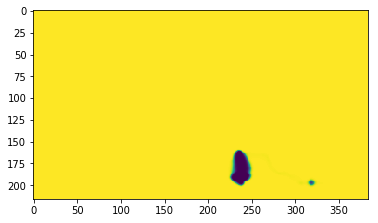

In [182]:
plt.imshow(cost_mats[stems[0]][4], interpolation="nearest")

## Path-finding Algorithm
Initialize:
- minCosts: a 2D array for the minimum costs to arrive at a particular cell, initialized to POSITIVE_INFINITY
- cellTo: a 2D array for which cell leads to a particular cell in this associated minimum cost path, initialize to -1

Starting from the source cell, for each cell:
- dequeue cell from queue, call this cell curr
- initialize boolean variable "updatedCells" to False
- compute the cost of walking from curr to neighbor in any of the 4 / 8 directions. Cost = ((curr_cost + neighbor_cost) / 2 ) * dist_curr_to_neighbor
- if any cell cost is less than corresponding entry in minCosts array, update both minCosts and cellTo array. Also set updatedCells to True.
- if any cell is not already in the queue, enqueue that cell

Repeat the above process until no values change in the minCost array, or until updatedCells is False for every cell in the matrix. Will require multiple passes over the matrix. When the algorithm terminates, backtrack from dest to source in the cellTo array to get the minimum cost path.

In [27]:
# helper method to convert from 1D to 2D
def convert1D(idx, rows):
    return int(round(idx / rows)), int(idx % rows)

In [28]:
# helper method to convert from 2D to 1D
def convert2D(row, i, j):
    return (row * i) + j

In [29]:
# helper method to check if a given point is within image bounds
def in_grid(i, j, row, col):
    return (i >= 0 and i < row and j >= 0 and j < col)

In [30]:
# source and dest are given as [x, y]
def find_path(mat, source, dest):
    q = []
    dist_q = []
    q.append(source)
    
    minCosts, cellTo = np.zeros(mat.shape), np.zeros((mat.shape[0], mat.shape[1], 2))
    minCosts.fill(float("inf")) # initialize all costs to infinity
    cellTo.fill(-1) # initialize all indices to -1
    
    dx = [-1, 0, 1, 0, 1, -1, 1, -1]
    dy = [0, 1, 0, -1, 1, -1, -1, 1]
    
    sourcex, sourcey = source[0], source[1]
    minCosts[sourcex][sourcey] = 0 # not sure if this is necessary
    dist_q.append(minCosts[sourcex][sourcey])
    updated = False
    image_counter = 0
    visualizations = []
    
    while len(q) != 0:
        min_idx = np.argmin(dist_q)
        curr = q.pop(min_idx)
        dist_q.pop(min_idx)
        updated = False
        
        # add current minCosts array for visualization purposes
        if image_counter % 100 == 0 and (image_counter > 100 or image_counter == 0):
            visualizations.append(minCosts.copy())
        image_counter += 1
        
        # looping through all neighbours 
        for i in range(len(dx)): 
            x = curr[0] + dx[i]
            y = curr[1] + dy[i]
            
            # if not inside boundary, ignore this neighbor 
            if not in_grid(x, y, mat.shape[0], mat.shape[1]): 
                continue
                
            # calculate cost of going from curr to [x, y]
            dist = 1 if abs(dx[i] - dy[i]) == 1 else 1.5
            cost = (mat[curr[0]][curr[1]] + mat[x][y]) * dist
            total_cost = minCosts[curr[0]][curr[1]] + cost
            
            # if cost is less than current cost, update both minCosts and cellTo
            if total_cost < minCosts[x][y]:
                minCosts[x][y] = total_cost
                cellTo[x][y] = [curr[0], curr[1]]
                updated = True
                
                # enqueue [x, y] if not already there
                if [x, y] not in q:
                    q.append([x, y])
                    dist_q.append(minCosts[x][y])
                else:
                    idx = q.index([x, y])
                    dist_q[idx] = minCosts[x][y]
                
    
    print(cellTo[dest[0]][dest[1]])
    return minCosts, cellTo, visualizations
                

In [183]:
# sources = [[193, 250], [198, 380], [159, 267]]
# dests = [[163, 123], [159, 268], [215, 373]]

minCosts = {}
cellTos = {}
visualizations = {}

for i in range(len(stems)):
    minCosts[stems[i]], cellTos[stems[i]], visualizations[stems[i]] = [], [], []
    for j in range(len(sources[stems[i]])):
        minCost, cellTo, vis = find_path(cost_mats[stems[i]][j], sources[stems[i]][j], dests[stems[i]][j])
        minCosts[stems[i]].append(minCost)
        cellTos[stems[i]].append(cellTo)
        visualizations[stems[i]].append(vis)

[160. 268.]
[215. 372.]
[164. 123.]
[193. 372.]
[214. 321.]
[183.   1.]
[130. 254.]
[213. 321.]
[213. 206.]
[188. 382.]
[101. 163.]
[116.   1.]
[ 29. 134.]
[132. 381.]
[ 40. 150.]
[149. 215.]
[104. 184.]
[214. 198.]
[151. 228.]
[209. 155.]
[127. 283.]
[109. 238.]
[127. 208.]
[102. 369.]
[127. 250.]
[125. 204.]
[206.  12.]
[145. 146.]
[104. 205.]
[101. 291.]
[158. 248.]
[183. 279.]
[179. 131.]
[213. 180.]
[205.  12.]
[180. 378.]
[ 97. 283.]
[137. 291.]
[111. 255.]
[103. 132.]


## Visualize Dijkstra

In [14]:
# visualizations for how the minCosts array changes as Dijkstra progresses
idx = 0
path = "cost_vis/barcelona/" + str(idx) + "/"
cost_vis = []
cmap_im = np.array(cv2.imread("sample_images/barcelona_small.png"))
cmap_im = cmap_im / 255.0
for i in range(len(visualizations[idx])):
    if (i % 5 == 0 and (i >= 5 or i == 0)) or (i == len(visualizations[idx]) - 1):
        plt.imsave(path + "frame" + str(i) + ".png", visualizations[idx][i], cmap="viridis")

for i in range(len(visualizations[idx])):
    if (i % 5 == 0 and (i >= 5 or i == 0)) or (i == len(visualizations[idx]) - 1):
        vis = np.array(cv2.imread(path + "frame" + str(i) + ".png")) / 255.0
        vis = vis*0.8 + cmap_im*0.2
        plt.imsave(path + "frame" + str(i) + ".png", vis)

KeyError: 0

## Backtracking to get path

In [15]:
# backtrack from dest to find path
def backtrack(cellTo, source, dest, cost_im):
    print(cost_im.shape)
    path, vis = [], []
    curr, prev = dest, [-1, -1]
    im = np.ones((cellTo.shape[0], cellTo.shape[1], 3))
    
    while prev != source:
        next_cell = cellTo[curr[0]][curr[1]]
        next_cell = [int(next_cell[0]), int(next_cell[1])]
        cost_im[next_cell[0]][next_cell[1]] = [0, 255, 0]
        path.append([next_cell[0], next_cell[1]])
        prev = curr
        curr = next_cell
        vis.append(cost_im.copy())
    
    return path, vis   

In [32]:
# same method but no cost matrix required
# backtrack from dest to find path
def backtrack2(cellTo, source, dest):
    path, vis = [], []
    curr, prev = dest, [-1, -1]
    
    while prev != source:
        next_cell = cellTo[curr[0]][curr[1]]
        next_cell = [int(next_cell[0]), int(next_cell[1])]
        path.append([next_cell[0], next_cell[1]])
        prev = curr
        curr = next_cell
    
    return path

In [17]:
import re

_nsre = re.compile('([0-9]+)')
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(_nsre, s)]   

In [18]:
# get base image (the heatmap of the cost image)
import os
idx = 0
path = "cost_vis/barcelona/" + str(idx) + "/"
li = os.listdir(path)
li.sort(key=natural_sort_key)
cmap_cost = np.array(cv2.cvtColor(plt.imread(path + li[-1]), cv2.COLOR_BGRA2BGR))
cmap_cost = cmap_cost*0.8 + cmap_im*0.2

# draw circle at source and dest
cmap_cost = cv2.circle(cmap_cost, (sources[idx][1], sources[idx][0]), 2, (0, 0, 1), 2)
cmap_cost = cv2.circle(cmap_cost, (dests[idx][1], dests[idx][0]), 2, (1, 0, 0), 2) 
plt.imshow(cmap_cost)

KeyError: 0

In [184]:
# GENERAL BACKTRACKING LOOP

trajs = {}

for i in range(len(stems)):
    trajs[stems[i]] = []
    for j in range(len(sources[stems[i]])):
        traj = backtrack2(cellTos[stems[i]][j], sources[stems[i]][j], dests[stems[i]][j])
        traj.pop(-1)
        trajs[stems[i]].append(np.flip(traj))
    
    print(len(trajs[stems[i]]))
    

5
5
5
5
5
5
5
5


In [749]:
# INDEX-SPECIFIC BACKTRACKING CODE

trajs, backtrack_vis = [], []

traj, vis = backtrack(cellTos[idx], sources[idx], dests[idx], cmap_cost)
traj.pop(-1)
trajs.append(np.flip(traj))

(216, 384, 3)


In [689]:
# save backtracking visualizations
backtrack_path = "backtrack_vis/barcelona/" + str(idx) + "/"

for i in range(len(vis)) :
    if i % 5 == 0 and (i >= 5 or i == 0):
        plt.imsave(backtrack_path + "frame" + str(i) + ".png", vis[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

## Straight-line Path Finding Algorithm

In [185]:
def find_straight_path(source, dest):
    y_vector = dest[1] - source[1]
    x_vector = dest[0] - source[0]
        
    path = []
    multiplier = 0.001
    prev_pt = [-1, -1]
    
    while multiplier <= 1:
        curr_x = round(source[0] + (x_vector * multiplier))
        curr_y = round(source[1] + (y_vector * multiplier))        
        
        if curr_x != prev_pt[0] or curr_y != prev_pt[1]:
            prev_pt = [curr_x, curr_y]
            path.append([curr_y, curr_x])
        
        multiplier += 0.001
    
    return path

In [186]:
# find straight line paths from sources to dests
straight_paths = {}
for i in range(len(stems)):
    straight_paths[stems[i]] = []
    for j in range(len(sources[stems[i]])):
        path = find_straight_path(sources[stems[i]][j], dests[stems[i]][j])
        straight_paths[stems[i]].append(path)

print(len(straight_paths[stems[0]]), len(straight_paths[stems[0]][0]))

5 150


## Visualize trajectory

In [34]:
# given a trajectory, goes through each point and modifies image
def draw_traj(traj, im, draw_pts=False):
    img = im.copy()
    
    # color each pt green
    for pt in traj:
        x, y = pt[0], pt[1]
        img[y][x] = [0, 255, 0]
        
    
    if draw_pts:
        img = cv2.circle(img, (traj[0][0], traj[0][1]), 2, (0, 0, 255), 2)
        img = cv2.circle(img, (traj[len(traj) - 1][0], traj[len(traj) - 1][1]), 2, (255, 0, 0), 2)  
    
    return img

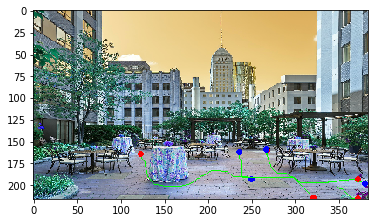

In [99]:
# Load corresponding image
stem_idx = 0
im = cv2.imread("oc_demo/walk_suburban.jpg")
im2 = im.copy()

for i in range(len(sources[stems[stem_idx]])):
    im2 = draw_traj(trajs[stems[stem_idx]][i], im2, True)
    
plt.imshow(im2)

In [36]:
# Visualize straight line trajectory
im3 = im.copy()
for i in range(len(sources[stems[stem_idx]])):
    im3 = draw_traj(straight_paths[stems[stem_idx]][i], im3, True)
    
plt.imshow(im3)

NameError: name 'straight_paths' is not defined

In [509]:
for i in range(len(stems)):
    img_filename = stems[i].split("_")
    img_filename = img_filename[0] + "_" + img_filename[1] + ".jpg"
    curr_img = cv2.imread("oc_demo/" + img_filename)
    
    dijkstra_im = curr_img.copy()
    straight_im = curr_img.copy()
    
    for j in range(len(sources[stems[i]])):
        dijkstra_im = draw_traj(trajs[stems[i]][j], dijkstra_im, True)
        straight_im = draw_traj(straight_paths[stems[i]][j], straight_im, True)
    
    cv2.imwrite("sample_paths/dijkstra/" + img_filename, dijkstra_im)
    cv2.imwrite("sample_paths/straight/" + img_filename, straight_im)

## Compare Costs of Path-Finding Algs

In [187]:
def compute_path_cost(cost_mat, path):
    total = 0
    for pt in path:
        x = pt[0]
        y = pt[1]
        total += cost_mat[y][x]
    return total

In [188]:
# compute Dijkstra and Straight Line costs
dijkstra_costs = {}
dijkstra_path_lengths = {}
straight_costs = {}
straight_path_lengths = {}

for i in range(len(stems)):
    dijkstra_costs[stems[i]] = []
    dijkstra_path_lengths[stems[i]] = []
    straight_costs[stems[i]] = []
    straight_path_lengths[stems[i]] = []
    
    for j in range(len(sources[stems[i]])):
        d_cost = compute_path_cost(cost_mats[stems[i]][j], trajs[stems[i]][j])
        dijkstra_costs[stems[i]].append(d_cost)
        dijkstra_path_lengths[stems[i]] = len(trajs[stems[i]][j])
        
        s_cost = compute_path_cost(cost_mats[stems[i]][j], straight_paths[stems[i]][j])
        straight_costs[stems[i]].append(s_cost)
        straight_path_lengths[stems[i]] = len(straight_paths[stems[i]][j])

In [189]:
dijkstra_mean = []
dijkstra_weighted_mean = []
straight_mean = []
straight_weighted_mean = []

for i in range(len(stems)):
    d_costs = np.copy(dijkstra_costs[stems[i]])
    d_lengths = np.copy(dijkstra_path_lengths[stems[i]])
    dijkstra_mean.append(np.mean(d_costs))
    dijkstra_weighted_mean.append(np.mean(d_costs) * np.sum(d_lengths))
    
    s_costs = np.copy(straight_costs[stems[i]])
    s_lengths = np.copy(straight_path_lengths[stems[i]])
    straight_mean.append(np.mean(s_costs))
    straight_weighted_mean.append(np.mean(s_costs) * np.sum(s_lengths))

In [190]:
print(dijkstra_mean)
print(dijkstra_weighted_mean)
print(straight_mean)
print(straight_weighted_mean)

[2639460394.3116097, 2780770260.587138, 8598657708.864965, 3388916794.8113794, 2666308303.2704597, 6800538907.524618, 8033243112.97539, 3248786002.084373]
[295619564162.90027, 620111768110.9318, 2003487246165.5369, 362614097044.8176, 253299288810.69366, 714056585290.085, 2827701575767.3374, 682245060437.7184]
[11117459364.745468, 8453296765.531178, 12909993341.643135, 5628287474.5477915, 5610361937.896833, 15331320753.78889, 13248685773.2506, 12795450642.862614]
[1489739554875.8928, 2299296720224.4805, 3511518188926.9326, 422121560591.08435, 863995738436.1123, 2131053584776.6558, 4743029506823.715, 1893726695143.6667]


In [191]:
def plot_barchart(arr1, arr2, x_labels):
    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars1 = np.copy(arr1)
    bars2 = np.copy(arr2)

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, bars1, color="#1763a6", width=barWidth, edgecolor='white', label='Dijkstra')
    plt.bar(r2, bars2, color= "#fd6b0b", width=barWidth, edgecolor='white', label='Straight Line')

    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], x_labels, rotation = 25)

    # Create legend & Show graphic
    plt.legend()
    plt.show()


In [192]:
def plot_barchart_five(arrs, x_labels):
    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars1 = np.copy(arr1)
    bars2 = np.copy(arr2)
    bars3 = np.copy(arr3)
    bars4 = np.copy(arr4)
    bars5 = np.copy(arr5)

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    
    # Make the plot
    plt.bar(r1, bars1, color="#1763a6", width=barWidth, edgecolor='white', label='Path 1')
    plt.bar(r2, bars2, color= "#fd6b0b", width=barWidth, edgecolor='white', label='Path 2')
    plt.bar(r2, bars3, color= "#fd6b0b", width=barWidth, edgecolor='white', label='Path 3')
    plt.bar(r2, bars4, color= "#fd6b0b", width=barWidth, edgecolor='white', label='Path 4')
    plt.bar(r2, bars5, color= "#fd6b0b", width=barWidth, edgecolor='white', label='Path 5')

    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], x_labels, rotation = 25)

    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [193]:
x_labels = ["suburban", 
            "barcelona", 
            "timessquare", 
            "parkinglot", 
            "sanmarco", 
            "turin", 
            "london",
            "germany"]

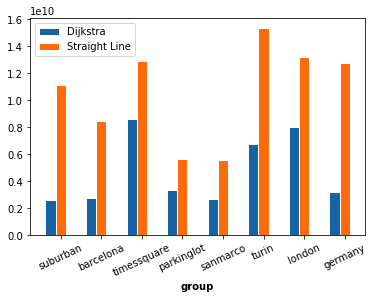

In [194]:
plot_barchart(dijkstra_mean, straight_mean, x_labels)

<IPython.core.display.Javascript object>


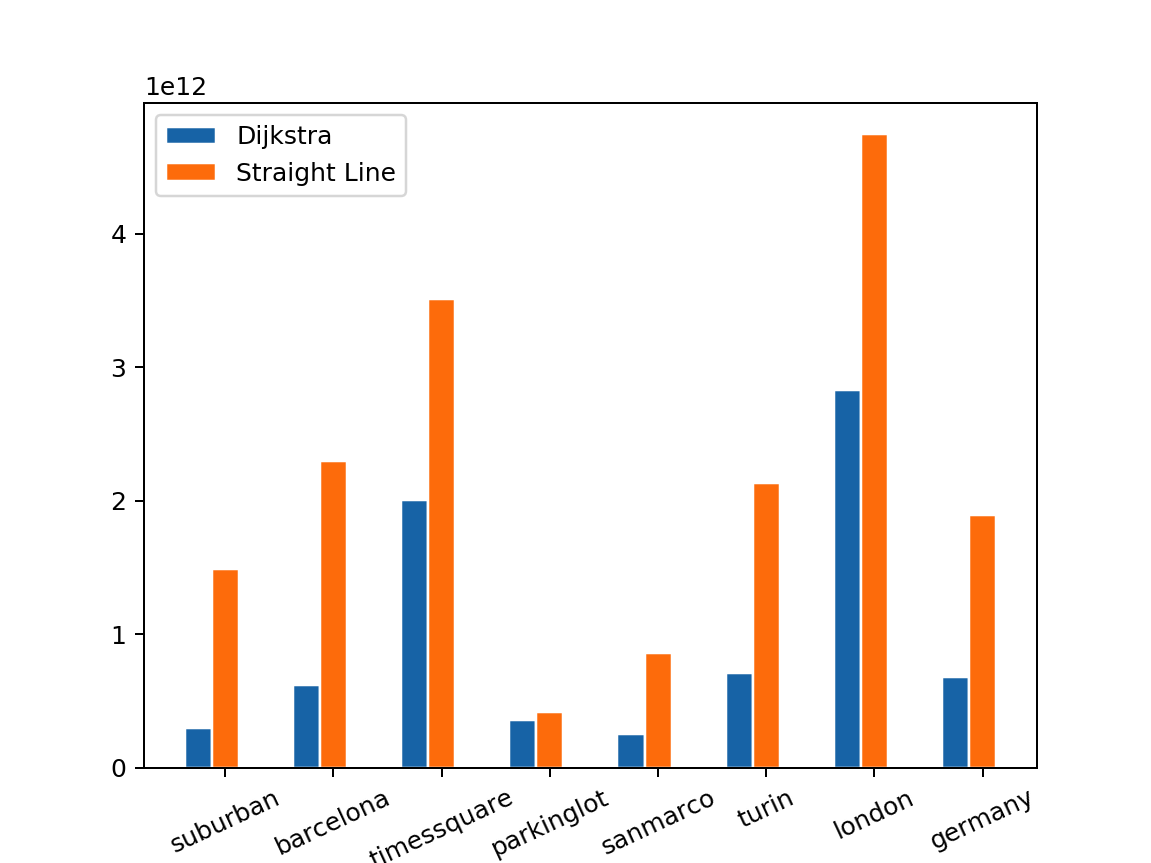

In [198]:
plot_barchart(dijkstra_weighted_mean, straight_weighted_mean, x_labels)

## Load MoCap Data

In [37]:
# read in motion capture video
def load_mocap(path):
    vid = cv2.VideoCapture(path)
    frames =  int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # iterate through each frame and store pixel values in matrix
    frame_matrix = []
    for t in range(frames):
        ret, frame = vid.read()
        resized = cv2.resize(frame, (width, height), interpolation = cv2.INTER_LINEAR)
        frame_matrix.append(resized)

    return np.stack(frame_matrix, axis=0)

In [38]:
path = 'mo_cap/16_32.mov'
frames = load_mocap(path)
print(frames.shape)

(6, 240, 320, 3)


In [39]:
for i in range(len(frames)):
    cv2.imwrite("cropped_figures/frame" + str(i) + ".jpg", frames[i])

## Crop MoCap Figures
Crop using OpenCV's Pedestrian Detection

In [40]:
from imutils.object_detection import non_max_suppression
from imutils import paths
import imutils

def crop_figure(frames):
    # initialize the HOG descriptor/person detector
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    cropped = []
    hog_vis = []

    # Pedestrian detection
    for image in frames:
        # load the image and resize it to (1) reduce detection time
        # and (2) improve detection accuracy
        img = image.copy()
        img = imutils.resize(img, width=min(400, img.shape[1]))

        # detect people in the image
        (rects, weights) = hog.detectMultiScale(img, winStride=(2, 2),
            padding=(4, 4), scale=0.95)

        # apply non-maxima suppression to the bounding boxes using a
        # fairly large overlap threshold to try to maintain overlapping
        # boxes that are still people
        rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
        pick = non_max_suppression(rects, probs=None, overlapThresh=0.5)

        for (xA, yA, xB, yB) in pick:
            cropped.append(img[yA+20:yB-25, xA+20:xB-15])
        
        # draw the final bounding boxes
        for (xA, yA, xB, yB) in pick:
            hog_vis.append(cv2.rectangle(image, (xA+20, yA+20), (xB-15, yB-25), (0, 255, 0), 2))
    return np.array(cropped), np.array(hog_vis)

In [41]:
cropped_figures, hog_vis = crop_figure(frames)

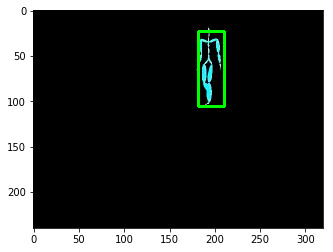

In [42]:
plt.imshow(hog_vis[4])

In [43]:
for i in range(len(cropped_figures)):
    cv2.imwrite("cropped_figures/" + str(i) + ".jpg", cropped_figures[i])
    cv2.imwrite("cropped_figures/bbox" + str(i) + ".jpg", hog_vis[i])

## Isolate MoCap figure from background

In [44]:
# essentially erase black background
def isolate_figure(frames):
    arr = []
    # convert to RGBA
    for i in range(frames.shape[0]):
        arr.append(cv2.cvtColor(frames[i], cv2.COLOR_BGR2BGRA))
        
    for i in range(frames.shape[0]):
        for j in range(frames.shape[1]):
            for k in range(frames.shape[2]):
                if arr[i][j][k][1] < 20:
                    arr[i][j][k] = [0, 0, 0, 0]
                else:
                    arr[i][j][k] = [0, 255, 0, 255]
    return arr

In [45]:
isolated_frames = isolate_figure(cropped_figures)

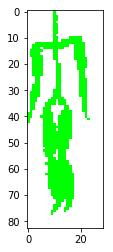

In [46]:
plt.imshow(isolated_frames[1])

In [47]:
for i in range(len(cropped_figures)):
    cv2.imwrite("cropped_figures/isolated" + str(i) + ".png", isolated_frames[i])

# Stitch MoCap data along trajectory
Steps:  
1. Identify horizon point
2. Compute figure height in any given point in the image
3. For each point in the trajectory, figure out movement direction and stitch corresponding figure onto location.

## Identify horizon point and compute height given point in image
h = h_max * (y - y_hor / (y_max - y_hor))

<IPython.core.display.Javascript object>


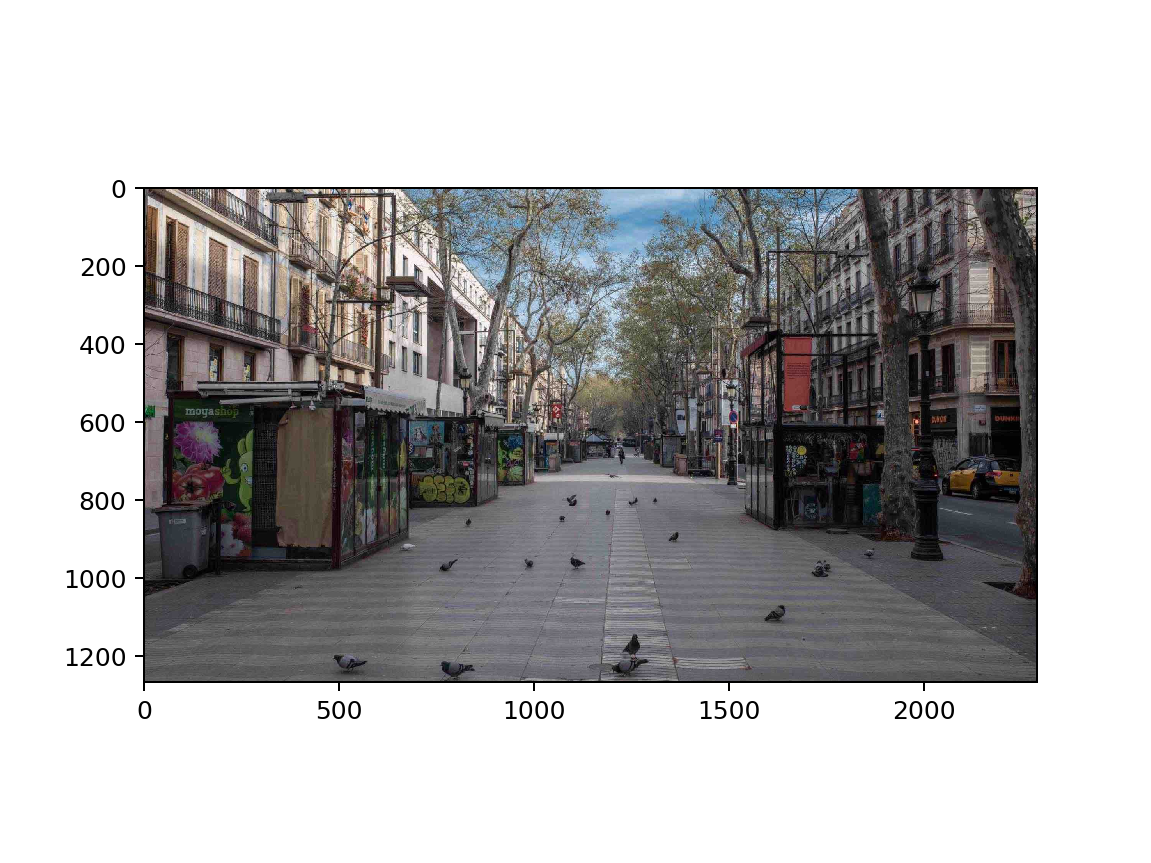

(1268, 2290, 4)


In [203]:
# Load sample image and identify horizon point
im = cv2.imread("sample_images/barcelona.jpg")
im = image_resize(im, width=2290, height=1288)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
print(im.shape)

In [204]:
# y coord is roughly ~25
horizon = 652
y_max = im.shape[0]

# rough maximum height of a figure if it is closest to the camera
h_max = 623

In [205]:
# returns height at random point in image
def getRelativeHeight(horizon, y_max, h_max, y_curr):
    height = h_max * ((y_curr - horizon) / (y_max - horizon))
    if height < 0:
        return 0
    else:
        return height

In [206]:
# point closest to camera
getRelativeHeight(horizon, y_max, h_max, y_max)

623.0

In [207]:
# point right at horizon line
getRelativeHeight(horizon, y_max, h_max, 1800)

1161.0454545454545

In [208]:
# point somewhere in the middle
getRelativeHeight(horizon, y_max, h_max, 160)

0

## Stitching

In [199]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
        
    if dim[0] == 0:
        dim = (1, dim[1])
    if dim[1] == 0:
        dim = (dim[0], 1)

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return cv2.cvtColor(resized, cv2.COLOR_BGR2BGRA)

In [106]:
def scaleFigures(frames, h_max):
    scaled_figures = []
    for i in range(len(frames)):
        im = image_resize(frames[i].copy(), height=h_max)
        scaled_figures.append(im)
    
    return scaled_figures

### Scale Figures and Trajectory for Stitching

In [57]:
# scale figures
resized_figures = scaleFigures(isolated_frames, h_max)

In [58]:
# smooth image with blur
# resized_figures = [cv2.GaussianBlur(figure, (7, 7), 3) for figure in resized_figures]

[0 0 0 0]


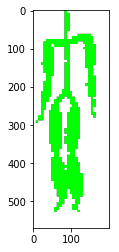

In [59]:
plt.imshow(resized_figures[0])
print(resized_figures[0][0][0])

In [209]:
# go through trajectory and resize points for new image (only for this example!!)
(h1, w1) = cost_mats[stems[0]][0].shape
h2, w2 = im.shape[0], im.shape[1]
yScale = h2 / h1
xScale = w2 / w1
print(yScale, xScale)

5.87037037037037 5.963541666666667


In [210]:
cost_mats[stems[0]][0].shape

(216, 384)

In [211]:
def scaleTraj(xScale, yScale, traj):
    new_traj = []
    for i in range(len(traj)):
        pt = traj[i]
        new_traj.append([int(round(pt[0]*yScale)), int(round(pt[1]*xScale))])
    return new_traj

In [212]:
scaled_trajs = {}
for i in range(len(stems)):
    scaled_trajs[stems[i]] = [scaleTraj(xScale, yScale, traj) for traj in trajs[stems[i]]]

In [111]:
scaled_trajs[stems[0]] = scaled_trajs[stems[i]][2:5]

### Stitch figures onto frames

In [147]:
def combine_two_color_images_with_anchor(image1, image2, anchor_y, anchor_x, height, color, alpha):
    foreground, background = image1.copy(), image2.copy()
    # Check if the foreground is inbound with the new coordinates and raise an error if out of bounds
    background_height = background.shape[1]
    background_width = background.shape[1]
    foreground_height = foreground.shape[0]
    foreground_width = foreground.shape[1]
    
    # do composite at specified location
    start_y = anchor_y - round(height)
    start_x = anchor_x - image1.shape[1]
    end_y = anchor_y
    end_x = anchor_x
    
    kernel = np.ones((5, 5),np.uint8)
    red, green, blue, alphaChannel = foreground.T
    transparent = (alphaChannel == 0)
    opaque = (alphaChannel != 0)
    foreground[opaque.T] = color
    foreground = cv2.GaussianBlur(cv2.dilate(foreground, kernel), (5, 5), 3)
    red, green, blue, alphaChannel = foreground.T
    transparent = (alphaChannel < 130)
    opaque = (alphaChannel >= 130)
    
#     if required_height < foreground_height:
#         print("entered if 1")
#         return background
#         # foreground = foreground[0:required_height,:]
    
#     if required_width < foreground_width:
#         print("entered if 2")
#         return background
#         # foreground = foreground[:, 0:required_width]
    
    if foreground.shape[0] == 0 or foreground.shape[1] == 0:
        print("entered if 3")
        return background
    
    
    blended_portion = cv2.addWeighted(foreground,
                alpha,
                background[start_y:end_y, start_x:end_x,:],
                1 - alpha,
                0,
                background)

    # dilate and then blur the figure
    blended_portion[transparent.T] = cv2.dilate(blended_portion[transparent.T], kernel)
    blended_portion[transparent.T] = cv2.GaussianBlur(blended_portion[transparent.T], (5, 5), 3)

    # set background pixels to the figure
    background[start_y:end_y, start_x:end_x,:][opaque.T] = blended_portion[opaque.T]
    
    # recompute the transparent and opaque pixels based on the overlay
    red, green, blue, alphaChannel = blended_portion.T
    transparent, opaque = (alphaChannel < 160), (alphaChannel >= 150)
    
    # blur the background with the figure overlaid on it 
    background[start_y:end_y, start_x:end_x,:] = cv2.GaussianBlur(cv2.dilate(background[start_y:end_y, start_x:end_x,:], kernel), (5, 5), 3)

    # set the background pixels back to their original color
    background[start_y:end_y, start_x:end_x,:][transparent.T] = image2.copy()[start_y:end_y, start_x:end_x,:][transparent.T]
    return background

In [161]:
def stitchMoCapBasic(traj, figures, frames, horizon, h_max, offset, color, height_error):
    fig_num = 0 # keeps track of figure's frame number
    
    for i in range(len(traj)):
        x, y = traj[i][0], traj[i][1]
        curr_fig = figures[fig_num].copy()
        curr_frame = frames[i + offset].copy()
        
        # get height at this point and resize figure
        height = getRelativeHeight(horizon, len(curr_frame), h_max, y) * height_error
        resized_fig = scaleFigures([curr_fig], round(height))[0]
        
        if resized_fig.shape == (1, 1, 4):
            continue
        
        # test function combine_two_color_images_with_anchor
        alpha = 0.7
        curr_frame = combine_two_color_images_with_anchor(resized_fig, curr_frame, y, x, height, color, alpha)
        
        frames[i + offset] = curr_frame
        
        # update figure motion
        if fig_num == 5:
            fig_num = 0
        else:
            fig_num += 1
        
    return frames

In [214]:
# count number of points in each trajectory
stem_idx = 1
pause_length = 8
num_frames = 0
for traj in scaled_trajs[stems[stem_idx]]:
    num_frames += len(traj)
num_frames += (len(scaled_trajs[stems[stem_idx]]) - 1) * pause_length
print(num_frames)

822


In [215]:
# calculate offsets
offsets = {}
for i in range(len(stems)):
    offsets[stems[i]] = []
    running_sum = 0
    for traj in scaled_trajs[stems[stem_idx]]:
        offsets[stems[i]].append(running_sum)
        running_sum += len(traj) + pause_length
print(offsets)

{'walk_suburban_': [0, 228, 379, 470, 599], 'walk_barcelona_': [0, 228, 379, 470, 599], 'walk_timessquare_': [0, 228, 379, 470, 599], 'walk_perspective_': [0, 228, 379, 470, 599], 'walk_sanmarco_': [0, 228, 379, 470, 599], 'walk_turin_': [0, 228, 379, 470, 599], 'walk_london_': [0, 228, 379, 470, 599], 'walk_cityscapes_': [0, 228, 379, 470, 599]}


<IPython.core.display.Javascript object>


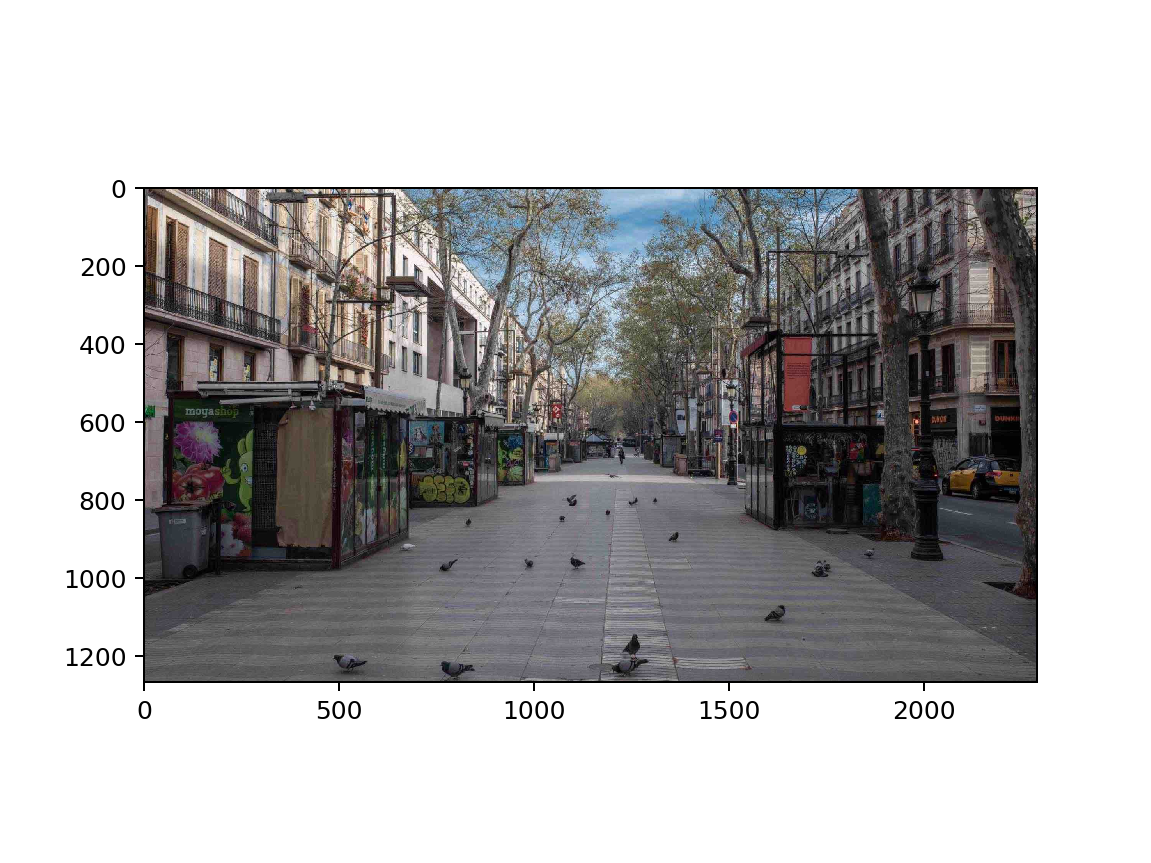

In [216]:
frames = []
for i in range(num_frames):
    frames.append(cv2.cvtColor(im.copy(), cv2.COLOR_BGR2RGBA))
plt.imshow(frames[0])

In [217]:
print(len(frames))

822


In [379]:
#frames[0] = cv2.cvtColor(im.copy(), cv2.COLOR_BGR2BGRA)

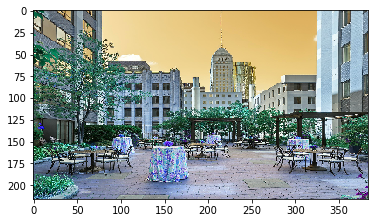

In [101]:
plt.imshow(frames[100])

In [218]:
# get the height errors for each person
height_errors = []
for i in range(len(scaled_trajs[stems[stem_idx]])):
    height_errors.append(np.random.uniform(0.8, 1.1))

In [220]:
# stitch figures onto frames
colors = [(23, 99, 166, 200), (253, 107, 11, 200), (36, 148, 30, 200)]
indexes = [3, 4]
for i in range(1, len(scaled_trajs[stems[stem_idx]])):
    color = colors[i % len(colors)]
    print(offsets[stems[stem_idx]][i])
    frames = stitchMoCapBasic(scaled_trajs[stems[stem_idx]][i], resized_figures, frames, horizon, h_max, offsets[stems[stem_idx]][i], color, height_errors[i])

228
379


error: OpenCV(4.1.2-openvino) /localdisk/jenkins/workspace/OpenCV/OpenVINO/build/opencv/modules/core/src/arithm.cpp:663: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


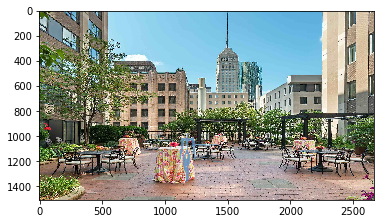

In [173]:
plt.imshow(frames[70])

In [131]:
def writeImages(frames, path):
    for i in range(len(frames)):
        if (i % 10 == 0 and i >= 10):
            cv2.imwrite(path + "/frame" + str(i) + ".jpg", cv2.cvtColor(frames[i], cv2.COLOR_BGRA2RGB))

In [132]:
path = "mocap_basic/suburban/hires/"
writeImages(frames, path)

In [175]:
def createAnimation(frames, path):
    height, width, layers = frames[0].shape
    size = (width,height)
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter(path, fourcc, 10, size)
 
    for i in range(len(frames)):
        out.write(frames[i])
        
    out.release()

In [176]:
createAnimation(frames, "mocap_basic/suburban_hires.avi")

## Evaluation

<IPython.core.display.Javascript object>


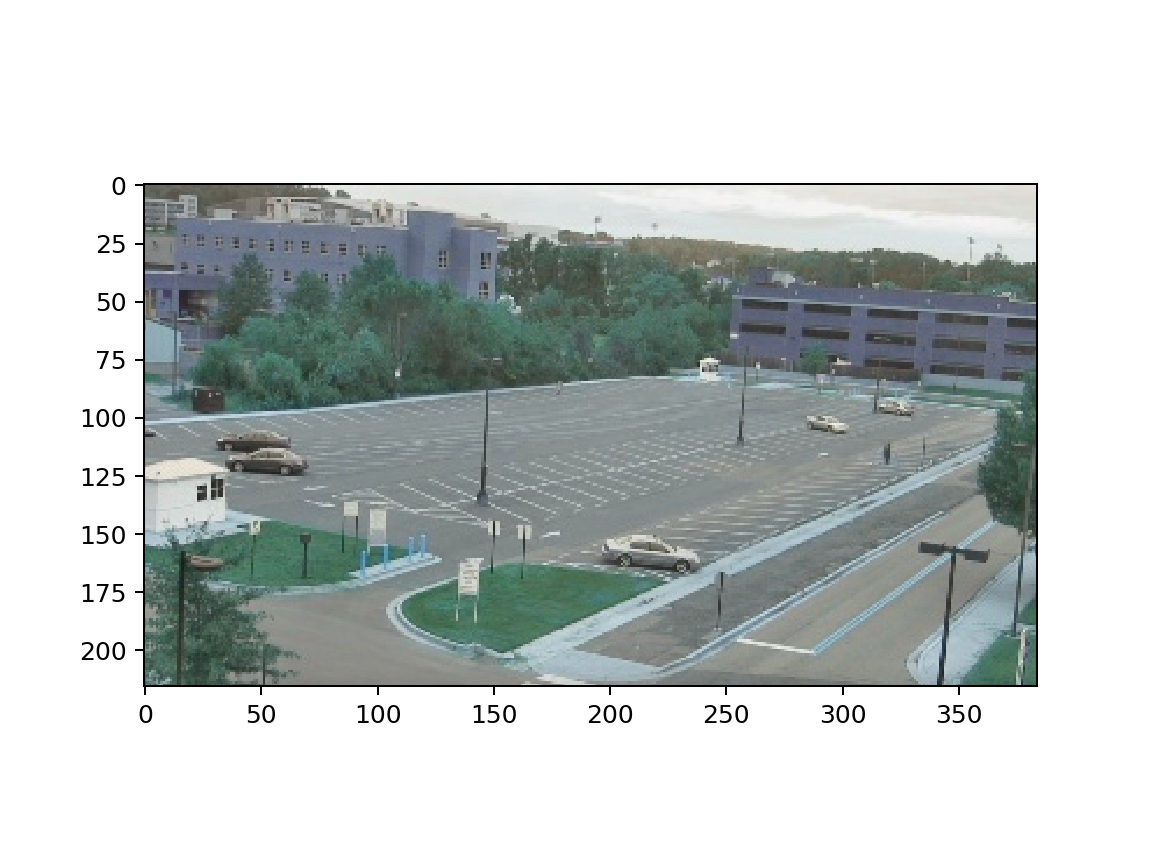

In [409]:
plt.imshow(cv2.imread("oc_demo/walk_perspective.jpg"))

## convert BGR to RGB

In [75]:
cpath = "mocap_basic/suburban/hires/"
file = "frame180.jpg"
cimg = cv2.imread(cpath + file)
cv2.imwrite(path + file, cimg)

True